In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from scipy.stats import multivariate_normal

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp

import os
import sys

# data preprocessing

In [4]:
dir_name = './real_data'
paths = os.listdir('./real_data')

automobile_p, spam_p, crime_norm_p, tem_p, crime_p = [os.path.join(dir_name, path) for path in paths]

dat = pd.read_csv(crime_p)

# ====================== data preprocessing ==========================
X = dat.iloc[:, :-1].to_numpy()
Y = dat.iloc[:, -1].to_numpy()
X.shape, Y.shape

((1993, 101), (1993,))

# Architecture

In [14]:
## ===================================================================== -->
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x) -->
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy




def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             regressor = MLPRegressor(hidden_layer_sizes=(256,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
#                                       learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01)
            regressor = LassoLarsIC(criterion='bic')
            regressor.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = regressor.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)

# training

In [22]:
# ============================= one run ==========================================
start = time.time()
# training steps

seed = 8
np.random.seed(seed)
torch.manual_seed(seed)


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train[:, np.newaxis]).ravel()
y_test = scaler_y.transform(y_test[:, np.newaxis]).ravel()

m = 1395
n = 101


# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)


actor = Actor(obs_dim=n+1, action_dim=n)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)

    
action_select = []
dictionary = dict()
r_list = []

r_baseline = torch.tensor(0)


x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)


for step in range(500):
    print('step: ', step)
    
    X_train, Y_train = get_data(x_tt, y_tt, batch_size=64)
    
    obs = np.concatenate((X_train, Y_train), axis=1) 
    actions, log_probs, entropy = actor(obs)
    action_select.append(actions.detach().numpy().mean(axis=0))
    
    # r_baseline = critic(X_train)
    # r_baseline = r_baseline.squeeze()
    
    
    rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
    
    # update actor
    actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    # actor_optimizer.zero_grad()
    # actor_loss.backward()
    # actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}\n')
    
    # update critic
    # critic_loss = F.mse_loss(r_baseline, rewards)
    # critic_optimizer.zero_grad()
    # critic_loss.backward()
    # critic_optimizer.step()
    # print(f'critic loss: {critic_loss.item()}\n')
    
#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 0.46505854179757217
step:  1
average reward: 0.4663912270159621
step:  2
average reward: 0.4602064408004804
step:  3
average reward: 0.46344657697740876
step:  4
average reward: 0.46798105105468835
step:  5
average reward: 0.4647655819923925
step:  6
average reward: 0.4607387585141659
step:  7
average reward: 0.46561841070789445
step:  8
average reward: 0.4611449659729546
step:  9
average reward: 0.4634754053632527
step:  10
average reward: 0.46417303076792205
step:  11
average reward: 0.46210375903270406
step:  12
average reward: 0.4621934927606994
step:  13
average reward: 0.46403740255907666
step:  14
average reward: 0.46121542546602023
step:  15
average reward: 0.46227222076243546
step:  16
average reward: 0.46501519775134026
step:  17
average reward: 0.46176202443469627
step:  18
average reward: 0.4614563505125754
step:  19
average reward: 0.4621877459617387
step:  20
average reward: 0.46313370084751704
step:  21
average reward: 0.460703234807748
step:  22

average reward: 0.45071596432029165
step:  180
average reward: 0.4488599091703647
step:  181
average reward: 0.45116828194799463
step:  182
average reward: 0.4495898413082853
step:  183
average reward: 0.4531012562874158
step:  184
average reward: 0.451199141028209
step:  185
average reward: 0.44967839957543443
step:  186
average reward: 0.4515595049915456
step:  187
average reward: 0.4492772570006147
step:  188
average reward: 0.4518291095128133
step:  189
average reward: 0.4506834975610464
step:  190
average reward: 0.4492346703540695
step:  191
average reward: 0.449462279642733
step:  192
average reward: 0.4517311047410979
step:  193
average reward: 0.4526738186784649
step:  194
average reward: 0.44998153551334674
step:  195
average reward: 0.449198847189276
step:  196
average reward: 0.45113904583000275
step:  197
average reward: 0.4500045413430883
step:  198
average reward: 0.44915844948406636
step:  199
average reward: 0.4498742661130384
step:  200
average reward: 0.4495562850417

average reward: 0.44640876413137265
step:  357
average reward: 0.44502516483109233
step:  358
average reward: 0.44453314690227297
step:  359
average reward: 0.44355940388515536
step:  360
average reward: 0.4456104913815706
step:  361
average reward: 0.44349674607439404
step:  362
average reward: 0.44559597610622226
step:  363
average reward: 0.4439184995939489
step:  364
average reward: 0.4438991149806184
step:  365
average reward: 0.4447994911705938
step:  366
average reward: 0.4438437478842385
step:  367
average reward: 0.44554121855297296
step:  368
average reward: 0.4452328885048362
step:  369
average reward: 0.4447541045524652
step:  370
average reward: 0.44387649289148223
step:  371
average reward: 0.4432485111983734
step:  372
average reward: 0.44296867340718926
step:  373
average reward: 0.4432784739805592
step:  374
average reward: 0.4436889259983043
step:  375
average reward: 0.44403603971789807
step:  376
average reward: 0.443973821312053
step:  377
average reward: 0.4437085

# plot

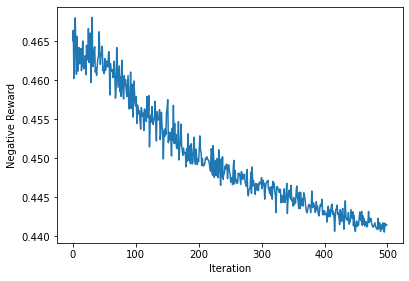

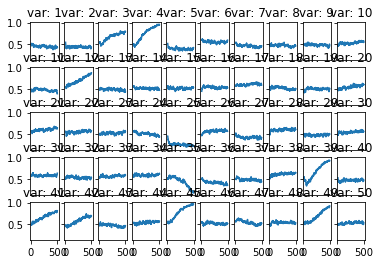

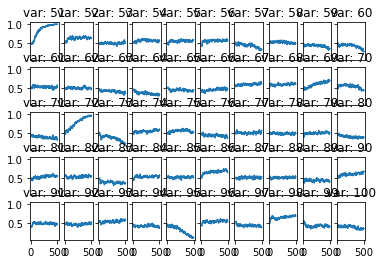

In [23]:
plt.figure()
plt.subplots_adjust(top=0.965,
bottom=0.145,
left=0.1,
right=0.9,
hspace=0.2,
wspace=0.2)
plt.plot(r_list)
# plt.xlim(0, 1000)
plt.xlabel('Iteration')
plt.ylabel('Negative Reward')
# plt.yticks([12, 20, 40, 60, 80, 100, 120])
# plt.hlines(12, 0, 1000, color='r')
# plt.savefig('1.eps')
'''
top=0.976,
bottom=0.094,
left=0.07,
right=0.984,
hspace=0.2,
wspace=0.2
'''


fig, axes = plt.subplots(5, 10, sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(5):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(action_select)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != 4: axes[i, j].set_xticks([]) 
        num += 1
        

fig, axes = plt.subplots(5, 10, sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 50
for i in range(5):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(action_select)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != 4: axes[i, j].set_xticks([]) 
        num += 1

In [25]:
tmp = sorted(dictionary.items(), key=lambda x: x[1])
s = set(range(n))
for item in tmp[:5]:
    s = s & set(item[0])
print(s)

with torch.no_grad():    
    obs = np.concatenate((x_train, y_train[:, np.newaxis]), axis=1)
    actions, log_probs, _ = actor(obs)
        
# print(np.where(np.array(action_select[-1]) > 0.95)[0]+1)        
print(np.where(np.array(action_select[-10:]).mean(axis=0) > 0.8)[0]+1)
print((torch.where(actions.mean(dim=0) > 0.8)[0] + 1).numpy())
print(np.array(list(s)) + 1)
# print('top 8')
# print(torch.topk(torch.tensor(action_select[-10:]).mean(axis=0), k=num_support))
# print(torch.topk(actions.mean(dim=0), k=num_support))

{4, 37, 71, 72, 74, 11, 13, 15, 50, 83, 90, 93}
[ 4 12 39 41 45 49 51 72]
[ 4 12 39 45 49 51 72]
[ 5 38 72 73 75 12 14 16 51 84 91 94]


# validation

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

In [4]:
x_train.shape

(1395, 101)

In [5]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train[:, np.newaxis]).ravel()
y_test = scaler.transform(y_test[:, np.newaxis]).ravel()

In [86]:
#======================== regression ====================================
print('lasso')
lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
lasso_bic.fit(x_train, y_train)
print(np.where(lasso_bic.coef_ != 0)[0] + 1)
lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
lasso_aic.fit(x_train, y_train)
print(np.where(lasso_aic.coef_ != 0)[0] + 1)
# lasso_cv = LassoCV(cv=5, fit_intercept=False, normalize=False)
# lasso_cv.fit(X, Y)
# print(np.where(lasso_cv.coef_ != 0)[0] + 1)
print('random forest')
regr = RandomForestRegressor(max_depth=5)
regr.fit(x_train, y_train)
sfm = SelectFromModel(regr, prefit=True)
print(np.where(sfm.get_support())[0] + 1)

lasso
[ 4 12 39 45 49 51 72 73 75]
[ 3  4  8 12 14 25 26 35 39 45 49 51 69 72 73 75 87 91 94]
random forest
[ 4 44 45 50 51 63 93]


In [68]:
reg = SVR()
reg.fit(x_train, y_train)

# x_test_num = x_test[:, :15]
# x_test_cat = x_test[:, 15:]
# x_test_num = scaler.transform(x_test_num)
# x_test = np.concatenate((x_test_num, x_test_cat), axis=1)
# x_test = scaler.transform(x_test)
np.mean(np.abs(y_test - reg.predict(x_test))), reg.score(x_train, y_train), reg.score(x_test, y_test)

(0.3580319833312646, 0.7421780925049977, 0.6007008389637728)

In [89]:
idx = (torch.where(actions.mean(dim=0) > 0.7)[0]).numpy()
'''
np.where(np.array(action_select[-10:]).mean(axis=0) > 0.9)[0]
(torch.where(actions.mean(dim=0) > 0.9)[0]).numpy()
np.array(list(s))
np.where(lasso_bic.coef_ != 0)[0]
np.where(lasso_aic.coef_ != 0)[0]
np.where(sfm.get_support())[0]

'''

x_train_sel = x_train[:, idx]
x_test_sel = x_test[:, idx]


reg_sel = SVR()
reg_sel.fit(x_train_sel, y_train)
np.mean(np.abs(y_test - reg_sel.predict(x_test_sel))), reg_sel.score(x_test_sel, y_test)

(0.3703795475231797, 0.5751154001753617)

In [29]:
tmp = sorted(dictionary.items(), key=lambda x: x[1])
s = set(range(n))
for item in tmp[:5]:
    s = s & set(item[0])


with torch.no_grad():  
    obs = np.concatenate((x_train, y_train[:, np.newaxis]), axis=1)
    actions, log_probs, _ = actor(obs)
        
      
idx1 = np.where(np.array(action_select[-10:]).mean(axis=0) > 0.8)[0]
idx2 = (torch.where(actions.mean(dim=0) > 0.8)[0]).numpy()
idx3 = np.array(list(s))


def compare_methods(x_train, y_train):
    # print('lasso')
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(x_train, y_train)
    # print(np.where(lasso_bic.coef_ != 0)[0] + 1)
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(x_train, y_train)
    # print(np.where(lasso_aic.coef_ != 0)[0] + 1)
    # print('random forest')
    regr = RandomForestRegressor(max_depth=5)
    regr.fit(x_train, y_train)
    sfm = SelectFromModel(regr, prefit=True)
    # print(np.where(sfm.get_support())[0] + 1)
    
    return np.where(lasso_aic.coef_ != 0)[0], np.where(lasso_bic.coef_ != 0)[0], np.where(sfm.get_support())[0]


idx_aic, idx_bic, idx_rf = compare_methods(x_train, y_train)



def metrics(idx, x_train, y_train, x_test, y_test):
    idx = idx

    x_train_sel = x_train[:, idx]
    x_test_sel = x_test[:, idx]
    
    
    reg = SVR()
    reg.fit(x_train_sel, y_train)
    
    return len(idx), np.mean(np.abs(y_test - reg.predict(x_test_sel))), reg.score(x_test_sel, y_test)


result = np.zeros((7, 3))

for i, idx in enumerate([idx1, idx2, idx3, idx_aic, idx_bic, idx_rf, range(n)]):
    result[i] = metrics(idx, x_train, y_train, x_test, y_test)


result = pd.DataFrame(result.T)
result.index = ['num', 'MAE', 'R2']
result.columns = ['acp1', 'acp2', 'acp3', 'aic', 'bic', 'rf', 'baseline']
result

,acp1,acp2,acp3,aic,bic,rf,baseline
num,8.000000,7.000000,12.000000,18.000000,13.000000,9.000000,101.000000
MAE,0.380509,0.380417,0.388851,0.383849,0.390372,0.382299,0.386694
R2,0.620565,0.623210,0.586355,0.589210,0.575215,0.598337,0.599102


# run different seeds

seed = 2, actor(n+1) steps250, threshold0.7, k5
seed = 3, actor(n+1) steps250, threshold0.8, k5     # 不错
seed = 5, actor(n+1) steps500, threshold0.95, k10
seed = 6, actor(n+1) steps500, threshold0.85, k10
seed = 7, actor(n+1)bic steps500, threshold0.95, k5     # 很好
seed = 8, actor(n+1)bic steps500, threshold0.8, k5     # 很好

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from scipy.stats import multivariate_normal

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp

import os
import sys

dir_name = './real_data'
paths = os.listdir('./real_data')

automobile_p, spam_p, crime_norm_p, tem_p, crime_p = [os.path.join(dir_name, path) for path in paths]

dat = pd.read_csv(crime_p)

# ====================== data preprocessing ==========================
X = dat.iloc[:, :-1].to_numpy()
Y = dat.iloc[:, -1].to_numpy()
# X.shape, Y.shape

## ===================================================================== -->
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x) -->
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy




def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             regressor = MLPRegressor(hidden_layer_sizes=(256,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
#                                       learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01)
            regressor = LassoLarsIC(criterion='bic')
            regressor.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = regressor.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)


def compare_methods(x_train, y_train):
    # print('lasso')
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(x_train, y_train)
    # print(np.where(lasso_bic.coef_ != 0)[0] + 1)
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(x_train, y_train)
    # print(np.where(lasso_aic.coef_ != 0)[0] + 1)
    # print('random forest')
    regr = RandomForestRegressor(max_depth=5)
    regr.fit(x_train, y_train)
    sfm = SelectFromModel(regr, prefit=True)
    # print(np.where(sfm.get_support())[0] + 1)
    
    return np.where(lasso_aic.coef_ != 0)[0], np.where(lasso_bic.coef_ != 0)[0], np.where(sfm.get_support())[0]


def metrics(idx, x_train, y_train, x_test, y_test):
    idx = idx

    x_train_sel = x_train[:, idx]
    x_test_sel = x_test[:, idx]
    
    
    reg = SVR()
    reg.fit(x_train_sel, y_train)
    
    return len(idx), np.mean(np.abs(y_test - reg.predict(x_test_sel))), reg.score(x_test_sel, y_test)

# =======================================================================
m = 1395
n = 101

def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


    scaler_x = StandardScaler()
    x_train = scaler_x.fit_transform(x_train)
    x_test = scaler_x.transform(x_test)

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train[:, np.newaxis]).ravel()
    y_test = scaler_y.transform(y_test[:, np.newaxis]).ravel()



    actor = Actor(obs_dim=n+1, action_dim=n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)


    action_select = []
    dictionary = dict()
    r_list = []

    r_baseline = torch.tensor(0)


    x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)


    for step in range(500):
#         print('step: ', step)

        X_train, Y_train = get_data(x_tt, y_tt, batch_size=64)

        obs = np.concatenate((X_train, Y_train), axis=1) 
        actions, log_probs, entropy = actor(obs)
        action_select.append(actions.detach().numpy().mean(axis=0))

        # r_baseline = critic(X_train)
        # r_baseline = r_baseline.squeeze()


        rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, num_iter=800, lr=1e-2, batch_size=64, dictionary=dictionary)
        r_list.append(rewards.mean())
#         print(f'average reward: {rewards.mean()}')
        rewards = torch.tensor(rewards, dtype=torch.float32)

        r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()

        # update actor
        actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}')

        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        # actor_optimizer.zero_grad()
        # actor_loss.backward()
        # actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}\n')

        # update critic
        # critic_loss = F.mse_loss(r_baseline, rewards)
        # critic_optimizer.zero_grad()
        # critic_loss.backward()
        # critic_optimizer.step()
        # print(f'critic loss: {critic_loss.item()}\n')

    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break
    
    
    action_select = np.array(action_select)
    
    tmp = sorted(dictionary.items(), key=lambda x: x[1])
    s = set(range(n))
    for item in tmp[:5]:
        s = s & set(item[0])


    with torch.no_grad():  
        obs = np.concatenate((x_train, y_train[:, np.newaxis]), axis=1)
        actions, log_probs, _ = actor(obs)


    idx1 = np.where(np.array(action_select[-10:]).mean(axis=0) > 0.8)[0]
    idx2 = (torch.where(actions.mean(dim=0) > 0.8)[0]).numpy()
    idx3 = np.array(list(s))
    
    idx_aic, idx_bic, idx_rf = compare_methods(x_train, y_train)
    
    result = np.zeros((7, 3))

    for i, idx in enumerate([idx1, idx2, idx3, idx_aic, idx_bic, idx_rf, range(n)]):
        result[i] = metrics(idx, x_train, y_train, x_test, y_test)
        
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return result


In [2]:
if __name__ == '__main__':   # 不加这个multiprocess会报错...
    # results = []
    # for sd in tqdm(range(20)):
    #     results.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
    start = time.time()
    pool = mp.Pool(10)
    dats = pool.map(run, range(10))
    pool.close() 
    end = time.time()
    print(datetime.timedelta(seconds = end - start))

random seed: 2 is runningrandom seed: 0 is runningrandom seed: 1 is runningrandom seed: 3 is running

random seed: 4 is running
random seed: 5 is running
random seed: 6 is runningrandom seed: 7 is running



random seed: 8 is running
random seed: 9 is running
rd: 3 take 1:30:03.745497
rd: 2 take 1:31:26.718646
rd: 7 take 1:33:02.357929
rd: 8 take 1:34:36.360407
rd: 9 take 1:34:54.842836
rd: 0 take 1:35:11.354473
rd: 6 take 1:35:11.571941
rd: 4 take 1:35:18.021250
rd: 5 take 1:35:18.126675
rd: 1 take 1:35:37.253206
1:35:37.488993


In [ ]:
start = time.time()
results = []
for sd in tqdm(range(10)):
    results.append(run(sd))
end = time.time()
print(datetime.timedelta(seconds = end - start))

In [3]:
dats = np.array([dat for dat in dats])

(10, 7, 3)

In [8]:
dats.mean(axis=0)

array([[  8.2       ,   0.38537167,   0.60316833],
       [  8.3       ,   0.38499403,   0.60467304],
       [  9.6       ,   0.392263  ,   0.59030479],
       [ 19.2       ,   0.38508502,   0.59141225],
       [  9.2       ,   0.38657099,   0.59193734],
       [  7.9       ,   0.39124169,   0.58484841],
       [101.        ,   0.38683931,   0.58764436]])

In [9]:
dats.std(axis=1)

array([[3.19393558e+01, 4.47630071e-03, 1.69335756e-02],
       [3.18331107e+01, 6.22769330e-03, 1.76769284e-02],
       [3.26840159e+01, 4.96379165e-03, 7.93812722e-03],
       [3.18023231e+01, 7.32023848e-03, 8.55918593e-03],
       [3.14136328e+01, 7.64483990e-03, 1.32702363e-02],
       [3.23053038e+01, 4.43874588e-03, 1.22316118e-02],
       [3.15251762e+01, 7.58796270e-03, 1.50653358e-02],
       [3.17792128e+01, 9.22316628e-03, 1.19157456e-02],
       [3.16923991e+01, 4.06033770e-03, 1.65105839e-02],
       [3.25682956e+01, 1.20649597e-02, 1.77169895e-02]])

In [11]:
dats[0]

array([[  7.        ,   0.37566623,   0.60963945],
       [  7.        ,   0.37566623,   0.60963945],
       [ 11.        ,   0.37383792,   0.59404301],
       [ 17.        ,   0.37584676,   0.5769175 ],
       [  9.        ,   0.37432485,   0.58984233],
       [ 10.        ,   0.38244464,   0.5794743 ],
       [101.        ,   0.3866316 ,   0.55908179]])

In [12]:
dats[1]

array([[ 10.        ,   0.38589573,   0.61926533],
       [ 10.        ,   0.38589573,   0.61926533],
       [ 12.        ,   0.38320854,   0.60965128],
       [ 20.        ,   0.38644614,   0.5942759 ],
       [  7.        ,   0.39854488,   0.58341295],
       [  6.        ,   0.40029533,   0.58110335],
       [101.        ,   0.39028935,   0.57268741]])

In [13]:
dats[2]

array([[  6.        ,   0.39816305,   0.58160486],
       [  7.        ,   0.39036766,   0.59777754],
       [  5.        ,   0.40342111,   0.57749166],
       [ 18.        ,   0.38810541,   0.60001483],
       [  6.        ,   0.39784019,   0.58327403],
       [  8.        ,   0.3925766 ,   0.59289902],
       [101.        ,   0.39825729,   0.58583616]])

In [14]:
dats[3]

array([[  9.        ,   0.36011383,   0.60816914],
       [ 10.        ,   0.36422426,   0.60439852],
       [  9.        ,   0.37256946,   0.60547756],
       [ 19.        ,   0.36568451,   0.59004327],
       [  9.        ,   0.36367183,   0.59753817],
       [  8.        ,   0.38105791,   0.58241762],
       [101.        ,   0.35803198,   0.60070084]])

In [15]:
dats[4]

array([[ 10.        ,   0.40018298,   0.58034131],
       [ 10.        ,   0.40018298,   0.58034131],
       [ 13.        ,   0.38199985,   0.60139626],
       [ 20.        ,   0.38408527,   0.61294973],
       [ 10.        ,   0.39069469,   0.59276864],
       [  8.        ,   0.38730852,   0.59035355],
       [101.        ,   0.38003266,   0.61559602]])

In [16]:
dats[5]

array([[  7.        ,   0.39442038,   0.6139697 ],
       [  7.        ,   0.39442038,   0.6139697 ],
       [  8.        ,   0.40102896,   0.60249498],
       [ 17.        ,   0.39749167,   0.59684034],
       [  9.        ,   0.38787289,   0.61829626],
       [  7.        ,   0.40012218,   0.58068487],
       [101.        ,   0.39077632,   0.59690514]])

In [17]:
dats[6]

array([[ 10.        ,   0.35213585,   0.61427977],
       [ 10.        ,   0.35213585,   0.61427977],
       [ 13.        ,   0.35320379,   0.61473913],
       [ 26.        ,   0.35852743,   0.5941998 ],
       [ 10.        ,   0.34982442,   0.6103478 ],
       [  6.        ,   0.37393146,   0.57036879],
       [101.        ,   0.35801389,   0.60249014]])

In [18]:
dats[7]

array([[  9.        ,   0.40613759,   0.5696748 ],
       [  9.        ,   0.40613759,   0.5696748 ],
       [  7.        ,   0.43521891,   0.54206367],
       [ 19.        ,   0.41904439,   0.54674551],
       [ 13.        ,   0.42129793,   0.53935085],
       [  8.        ,   0.42029926,   0.5482316 ],
       [101.        ,   0.41743819,   0.54352942]])

In [19]:
dats[8]

array([[  8.        ,   0.38050884,   0.62056518],
       [  7.        ,   0.38041747,   0.62321026],
       [ 12.        ,   0.38885064,   0.58635464],
       [ 18.        ,   0.38384871,   0.58921014],
       [ 13.        ,   0.39037245,   0.57521539],
       [  8.        ,   0.3795624 ,   0.6053837 ],
       [101.        ,   0.38669362,   0.59910209]])

In [20]:
dats[9]

array([[  6.        ,   0.40049219,   0.61417372],
       [  6.        ,   0.40049219,   0.61417372],
       [  6.        ,   0.42929081,   0.56933569],
       [ 18.        ,   0.39176991,   0.61292544],
       [  6.        ,   0.39126581,   0.62932696],
       [ 10.        ,   0.39481856,   0.61756735],
       [101.        ,   0.4022282 ,   0.6005146 ]])

In [23]:
dats[[0,1,3,5,6], :, :].mean(axis=0)

array([[  8.6       ,   0.3736464 ,   0.61306468],
       [  8.8       ,   0.37446849,   0.61231055],
       [ 10.6       ,   0.37676973,   0.60528119],
       [ 19.8       ,   0.3767993 ,   0.59045536],
       [  8.8       ,   0.37484777,   0.5998875 ],
       [  7.4       ,   0.38757031,   0.57880979],
       [101.        ,   0.37674863,   0.58637306]])

In [25]:
dats[[0,1,3,5,6], :, :].std(axis=0)

array([[1.356466  , 0.01569407, 0.00391004],
       [1.46969385, 0.01505846, 0.00499469],
       [1.8547237 , 0.01556637, 0.00696633],
       [3.31058907, 0.01399673, 0.00711096],
       [0.9797959 , 0.01721947, 0.01285407],
       [1.49666295, 0.01071614, 0.004324  ],
       [0.        , 0.01535645, 0.0173671 ]])

In [24]:
dats[[0,1,5,6,8], :, :].mean(axis=0)

array([[  8.4       ,   0.37772541,   0.61554389],
       [  8.2       ,   0.37770713,   0.6160729 ],
       [ 11.2       ,   0.38002597,   0.60145661],
       [ 19.6       ,   0.38043214,   0.59028874],
       [  9.6       ,   0.3801879 ,   0.59542295],
       [  7.4       ,   0.3872712 ,   0.583403  ],
       [101.        ,   0.38248096,   0.58605331]])

In [26]:
dats[[0,1,5,6,8], :, :].std(axis=0)

array([[1.356466  , 0.01422877, 0.00394971],
       [1.46969385, 0.01422524, 0.00469386],
       [1.72046505, 0.01604276, 0.01027314],
       [3.38230691, 0.01295925, 0.0071284 ],
       [1.95959179, 0.01706505, 0.01630747],
       [1.49666295, 0.0109128 , 0.01167179],
       [0.        , 0.01235634, 0.01711322]])

In [29]:
np.save('crime.npy', dats[[0,1,5,6,8], :, :])